# LIBRARIES IMPORT

In [8]:
# imports

import fig_lib 
import CNN_lib
import CNN_utilities
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import json


In [9]:
init_time = time.time()

In [10]:

generate_new_peakle=True
max_frames_allowed=40

json_fix_sq_p='C:\PROJECTS\emboendo\dicom_viewer\_static\Jsons\points_fix_d.json'
pkl_d_p = 'C:\PROJECTS\emboendo\CNN/pikles/input_d_processed.pkl'
pkl_train_p='C:\PROJECTS\emboendo\CNN\pikles/processed_train_d.pkl'   



# DATA LOAD

### PROCESSED IMAGES

In [11]:

with open(json_fix_sq_p, 'r') as json_file:
    json_d = json.load(json_file)
    


In [12]:

patients_recs_d_df=CNN_utilities.main_d_df()
patients_labels_d_df=CNN_utilities.labels_df()
patients_d_df=pd.merge( patients_labels_d_df,patients_recs_d_df, on='PatientID')

def find_recs(row):

    rec_true = [record for record in row['Records'] if record in list(json_d.keys())]

    return pd.Series({'recs_crop': rec_true})

new_col = patients_d_df.apply(find_recs, axis=1)
patients_d_df = pd.concat([patients_d_df, new_col], axis=1)
patients_d_df=patients_d_df.drop('Records', axis=1)
patients_d_df =  patients_d_df[patients_d_df['recs_crop'].apply(lambda x: x != [])]

display(patients_d_df)


,PatientID,Sex,Age,S.E.,M.A.,A.C.V.,label,recs_crop
0,62,0,67,0,0,0,0,"[I1, I11, I2, I9]"
1,76,1,72,0,0,0,0,"[I28, I33, I38, I39, I40, I42, I44, I45, I47, ..."
2,93,0,78,0,0,0,0,"[I51, I53, I54, I56, I57, I58, I61, I63, I64, ..."
3,103,0,82,1,0,0,1,"[I70, I71, I72, I73, I77]"
4,105,1,57,1,0,0,1,"[I101, I102, I103, I86, I87, I89, I90, I91, I9..."
...,...,...,...,...,...,...,...,...
83,109897,1,79,0,0,0,0,"[109897_1, 109897_2, 109897_3, 109897_4, 10989..."
84,669183,1,78,0,0,1,1,"[669183_1, 669183_10, 669183_2, 669183_3, 6691..."
85,670615,1,80,1,0,2,1,"[670615_10, 670615_13, 670615_14, 670615_15, 6..."
86,224436,1,77,0,0,0,0,"[224436_1, 224436_10, 224436_11, 224436_12, 22..."


In [13]:
  
tot_recs=sum(len(records) for records in patients_d_df['recs_crop'])
filtered_df_0,filtered_df_1 = patients_d_df[patients_d_df['label'] == 0],patients_d_df[patients_d_df['label'] == 1]
label_0,label_1 = sum(len(records) for records in filtered_df_0['recs_crop']),sum(len(records) for records in filtered_df_1['recs_crop'])

print(f'- PATIENTS: {patients_d_df.shape[0]} ,PATIENT LABEL 0: {sum(patients_d_df["label"]==0)}, PATIENT LABEL 1: {sum(patients_d_df["label"]==1)}')
print( f'- RECORDS: {tot_recs} , RECORDS LABEL 0: {label_0}, RECORDS LABEL 1:{label_1}')
print(f'- RATIO LABEL 0: {np.round(label_0/sum(patients_d_df["label"]==0),decimals=2)}, RATIO LABEL 1: {np.round(label_1/sum(patients_d_df["label"]==1),decimals=2)}')


- PATIENTS: 88 ,PATIENT LABEL 0: 63, PATIENT LABEL 1: 25
- RECORDS: 729 , RECORDS LABEL 0: 528, RECORDS LABEL 1:201
- RATIO LABEL 0: 8.38, RATIO LABEL 1: 8.04


In [14]:
if generate_new_peakle:
    
    input_d={}    

    for label,ii in zip(patients_d_df['label'],patients_d_df['recs_crop']):
        
        for rec in ii:

            input_d[rec]={'label':label}
            vd_ls=[]

            for i in range(len(json_d[rec])):
                
                if i== max_frames_allowed: break
                
                else:
                    try:
                        image_8bit=np.load(json_d[rec][str(i)]['cropped_image'])
                        #print(rec,label,i, np.shape(image_8bit))
                        width=np.shape(image_8bit)[0]
                        height = np.shape(image_8bit)[1]
                        vd_ls.append(image_8bit)
                    except:pass
                
            input_d[rec]['image']=np.array(vd_ls)
            input_d[rec]['dimHW']= [height,width]   
    
    with open(pkl_d_p, 'wb') as pikle_file:
        
        pickle.dump(input_d, pikle_file)

else: 

    with open(pkl_d_p, 'rb') as pikle_file:
        input_d = pickle.load(pikle_file)

# CHECK DATA

In [15]:
print('RECORD - LABEL - SHAPE')

#if d_type== 'synthetic':
    
for R in input_d.keys():
    print(R,input_d[R]['label'],np.shape(input_d[R]['image']),type(input_d[R]['image']))

RECORD - LABEL - SHAPE
I1 0 (40, 150, 150) <class 'numpy.ndarray'>
I11 0 (40, 160, 160) <class 'numpy.ndarray'>
I2 0 (40, 140, 140) <class 'numpy.ndarray'>
I9 0 (40, 150, 150) <class 'numpy.ndarray'>
I28 0 (23, 130, 130) <class 'numpy.ndarray'>
I33 0 (24, 130, 130) <class 'numpy.ndarray'>
I38 0 (24, 150, 150) <class 'numpy.ndarray'>
I39 0 (24, 130, 130) <class 'numpy.ndarray'>
I40 0 (20, 140, 140) <class 'numpy.ndarray'>
I42 0 (22, 140, 140) <class 'numpy.ndarray'>
I44 0 (23, 140, 140) <class 'numpy.ndarray'>
I45 0 (24, 140, 140) <class 'numpy.ndarray'>
I47 0 (23, 140, 140) <class 'numpy.ndarray'>
I49 0 (23, 140, 140) <class 'numpy.ndarray'>
I51 0 (39, 150, 150) <class 'numpy.ndarray'>
I53 0 (39, 150, 150) <class 'numpy.ndarray'>
I54 0 (39, 150, 150) <class 'numpy.ndarray'>
I56 0 (39, 150, 150) <class 'numpy.ndarray'>
I57 0 (39, 150, 150) <class 'numpy.ndarray'>
I58 0 (39, 150, 150) <class 'numpy.ndarray'>
I61 0 (39, 150, 150) <class 'numpy.ndarray'>
I63 0 (39, 150, 150) <class 'numpy.

In [16]:
d_plt_check,rec_check=True,'I1'
t_btw_frm=0.05
print(input_d[rec_check]['label'])


0


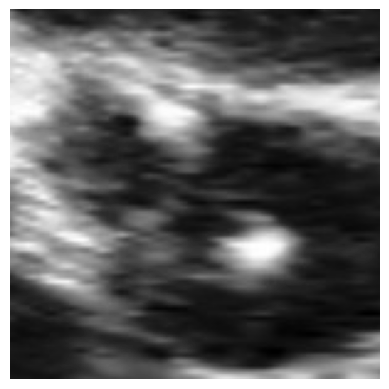

In [17]:
# check video

if d_plt_check:fig_lib.vid_show(input_d[rec_check]['image'],t_btw_frm=t_btw_frm)
    

# CNN

### GENERATE TRAIN DATA

In [19]:
# X_train,Y_train

X_train,Y_train,max_frm_n,HEIGHT, WIDTH =CNN_lib.vid_d_bin_gen(input_d, zero=0, one= 1,pad_type='zeros')


In [20]:
idx_permut = np.random.permutation(len(X_train))
X_train,Y_train=X_train[idx_permut],Y_train[idx_permut]
rec_check_ls=list(input_d.keys())
rec_check_ls=np.take(rec_check_ls, idx_permut)


In [21]:
save_trains=[X_train,Y_train]

with open(pkl_train_p, 'wb') as pikle_file:
        
        pickle.dump(save_trains, pikle_file)


In [22]:
end_time = time.time()

process_time = end_time - init_time
print(f"Tiempo transcurrido: {process_time} segundos")

Tiempo transcurrido: 352.55206203460693 segundos


### CHECK SAVED DATA

In [23]:
print(rec_check_ls)

['I1259' 'I720' 'I189' '6272_15' 'I1112' '646778_6' '178572_3' 'I303'
 '178572_2' '224436_18' 'I414' 'I961' '178572_12' 'I522' 'I533' '651399_7'
 '673676_15' 'I698' 'I63' 'I531' 'I810' '673676_13' 'I473' 'I712' 'I811'
 'I616' '673676_23' 'I1248' '272340_8' 'I622' 'I252' 'I632' 'I169' 'I418'
 'I1005' 'I960' 'I103' '670615_3' 'I723' 'I773' 'I264' '380772_10' 'I879'
 '656335_4' 'I45' 'I161' '512291_1' 'I986' 'I286' 'I1088' 'I623' 'I515'
 'I1027' 'I996' 'I270' 'I574' 'I1272' 'I343' 'I706' '385597_16' 'I1224'
 '656960_2' '385597_3' '651399_1' 'I1161' 'I281' 'I1110' 'I11' 'I91'
 'I835' 'I542' 'I739' 'I896' '646778_9' 'I255' 'I267' '178572_15' 'I484'
 'I781' 'I912' '547169_4' 'I147' 'I332' 'I167' '660022_7' '656960_7'
 '673676_3' 'I809' 'I962' '670615_19' 'I1145' 'I658' 'I730' 'I392' 'I101'
 'I588' 'I213' '272340_1' 'I983' 'I1119' 'I1215' 'I993' '6272_11'
 '380772_3' 'I488' 'I803' '670615_13' 'I767' 'I923' 'I707' 'I56'
 '673676_21' 'I391' 'I77' 'I1108' 'I535' '669183_5' 'I416' 'I567' 'I1043'


In [24]:
saved_rec_check='I696'
idx_check=list(rec_check_ls).index(saved_rec_check)

"""rec_check_ls
X_train
Y_train"""
print(rec_check_ls[idx_check],Y_train[idx_check])


I696 0


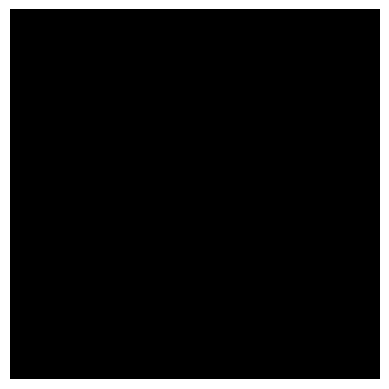

In [25]:
fig_lib.vid_show(X_train[idx_check],t_btw_frm=t_btw_frm)